# Detecting signs of depression - Part 0: Exploratory Data Analysis + Feature Engineering

* Authors:
    * Viosca Ros, Jose
    * Enrique Guillén, Raquel
    * Fernández Hernández, Alberto
 
__Date__: 2023 - 03 - 16

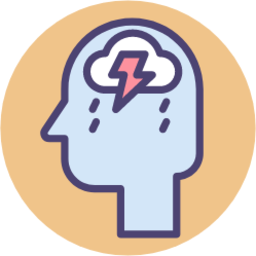

In [ ]:
# -- Install libraries
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install empath
!pip install textblob
!pip install readability
!pip install pyenchant
!pip install emot
!pip install NRCLex
!pip install vaderSentiment
!pip install syntok

In [2]:
# -- Libraries
from   transformers.pipelines.pt_utils import KeyDataset
from   sklearn.feature_extraction.text import TfidfVectorizer
from   transformers                    import AutoModelForSequenceClassification, AutoTokenizer
from   transformers                    import TFAutoModelForSequenceClassification
from   vaderSentiment.vaderSentiment   import SentimentIntensityAnalyzer
from   emot.emo_unicode                import UNICODE_EMOJI
from   emot.emo_unicode                import EMOTICONS_EMO
from   sklearn.metrics                 import cohen_kappa_score
from   transformers                    import pipeline
from   datasets                        import load_dataset
from   tqdm.auto                       import tqdm
from   empath                          import Empath
from   bs4                             import BeautifulSoup 
from   scipy                           import stats
from   textblob                        import TextBlob
from   gensim.utils                    import simple_preprocess
from   gensim.models                   import CoherenceModel
from   nltk.stem                       import WordNetLemmatizer
from   nltk.corpus                     import stopwords
from   nltk.tokenize                   import word_tokenize
from   unidecode                       import unidecode
from   nrclex                          import NRCLex
import matplotlib.pyplot               as plt
import seaborn                         as sns
import tqdm.notebook                   as tq
import pandas                          as pd
import numpy                           as np
import scipy                           as sp
import gensim.corpora                  as corpora
import syntok.segmenter                as segmenter
import transformers
import readability
import string
import spacy
import gensim
import torch
import pickle
import nltk
import glob
import shap
import ast
import re
import gc
%matplotlib inline

nltk.download('omw-1.4')
tqdm.pandas()
plt.style.use('ggplot')

# -- Constants
URL_REGEX = r'(?:(?:http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.(?:[a-zA-Z]){2,6}(?:[a-zA-Z0-9\.\&\/\?\:@\-_=#])*'
ERISK_2018_DEPRESSION = '/kaggle/input/erisk2018-dataset/erik2018_depression_test.csv'

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


## Auxiliary functions

In [3]:
# -- Function to get Part of Speech (POS) tags, using Spacy library (filtering by POS)
def get_pos_tags(tag):
    pos = []
    for doc in tqdm(nlp.pipe(erisk_df_no_blank_posts['cleaned_text'].values, batch_size=16), total=erisk_df_no_blank_posts.shape[0]):
        pos_list = [token.pos_ for token in doc if token.pos_ == tag]
        pos.append(len(pos_list))
    return pos

# -- Function to get Part of Speech (POS) tags, using Spacy library (filtering by TAG)
def get_pos_fine_grained(tag):
    erisk_df_no_blank_posts['cleaned_text'] = erisk_df_no_blank_posts['Text'].apply(lambda x: clean_text(str(x)))
    pos = []
    for doc in tqdm(nlp.pipe(erisk_df_no_blank_posts['cleaned_text'].values, batch_size=16), total=erisk_df_no_blank_posts.shape[0]):
        pos_list = [token.pos_ for token in doc if token.tag_ in tag]
        pos.append(len(pos_list))
    return pos

# -- Function to preprocess text (based on HugginFace transformer)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if 'http' in t else t
        new_text.append(t)
    return " ".join(new_text)

# -- Function to remove URLs from text
def clean_text_no_lower(x):
    return re.sub(r"(#[a-zA-Z0-9]+;)|(\/r\/[a-zA-Z]+)|([a-zA-Z%_0-9]+=[a-zA-Z0-9%&_\.-]* ?\)?\]?|(%[a-zA-Z0-9_\.=,\-\+%]+(watch|facebook|reddit|http|youtube\.)[a-zA-Z0-9_\.=,\-%\+]+( \+O%27Nymous)?\)?\]?))|(!\/?[a-zA-Z0-9.\/_]+\.[a-zA-Z]{2,3}\)?\]?)", "",
                  re.sub(r'\(?\[?(?:(?:http|https|www)\:*(\/+\/+\**|\.))[a-zA-Z0-9\.\/\?\:@\-_=#\*\\\.]+\.((?:[a-zA-Z]){2,6}(?:[a-zA-Z0-9\.\&\/\?\:@\-_=#\*\\\.])*)?\)?\]?', '', 
                  str(re.sub(' +', ' ', str(x))), flags=re.MULTILINE))

# -- Function (general) to clean texts (removing URLs, hashtags, punctuation sings, words with less than 2 chars) + lowercase
def clean_text(x):
    x = str(x).lower()
    x = re.sub(r"(#[a-zA-Z0-9]+;)|(\/r\/[a-zA-Z]+)|([a-zA-Z%_0-9]+=[a-zA-Z0-9%&_\.-]* ?\)?\]?|(%[a-zA-Z0-9_\.=,\-\+%]+(watch|facebook|reddit|http|youtube\.)[a-zA-Z0-9_\.=,\-%\+]+( \+O%27Nymous)?\)?\]?))|(!\/?[a-zA-Z0-9.\/_]+\.[a-zA-Z]{2,3}\)?\]?)", "",
                  re.sub(r'\(?\[?(?:(?:http|https|www)\:*(\/+\/+\**|\.))[a-zA-Z0-9\.\/\?\:@\-_=#\*\\\.]+\.((?:[a-zA-Z]){2,6}(?:[a-zA-Z0-9\.\&\/\?\:@\-_=#\*\\\.])*)?\)?\]?', '', 
                  str(re.sub(' +', ' ', str(x))), flags=re.MULTILINE))
    return x

## Feature engineering

In [5]:
## -- Mental Risk ES 23
train_df = pd.read_csv('/kaggle/input/task-2a-train-en-helsinki/task_2a_train_en_helsinki.csv', sep=';', encoding='latin-1')
train_df['type'] = 'train'
trial_df = pd.read_csv('/kaggle/input/task-2a-train-en-helsinki/task_2a_trial_en_helsinki.csv', sep=';', encoding='latin-1')
trial_df['type'] = 'trial'

erisk_df_no_blank_posts = pd.concat([train_df, trial_df], axis=0)
erisk_df_no_blank_posts.dropna(subset=['message_without_emojis'], inplace=True)
erisk_df_no_blank_posts.reset_index(drop=True, inplace=True)
erisk_df_no_blank_posts.rename(columns={'label': 'Class'}, inplace=True)
erisk_df_no_blank_posts.rename(columns={'message_without_emojis': 'Text'}, inplace=True)
erisk_df_no_blank_posts

,Column1,id_message,message,date,user_id,num_uppercase_words,message_emojized,Class,fe_num_pos_emojis,fe_num_neut_emojis,fe_num_neg_emojis,fe_sentiment_avg,Text,emojis,type
0,0,40756418041,face crying face please face please,10/08/2021 3:04,subject123,0.0,?? ?? ??,1,0,1,0,7,,?? ??,train
1,1,33659621738,There's face please.,10/08/2021 5:16,subject123,1.0,Hayy ??,1,0,0,0,0,Hayy,??,train
2,2,40687073955,I'm going through the same face of please brok...,10/08/2021 5:16,subject123,5.0,Estoy Pasando Por Lo Mismo ?? ?? ??,1,0,0,2,-122,Estoy Pasando Por Lo Mismo,?? ??,train
3,3,89212098652,And listen to each other face please,10/08/2021 5:17,subject123,3.0,Y Se Escuchan ??,1,0,0,0,0,Y Se Escuchan,??,train
4,4,95126906116,Since My Bridegroom died I do not know if to f...,10/08/2021 5:21,subject123,60.0,Desde Que Mi Novio Murió No Se Si Seguir Mi Vi...,1,0,0,5,-1162,Desde Que Mi Novio Murió No Se Si Seguir Mi Vi...,?? ?? ??,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6860,619,17560221872,"We respect what you need, but from experience....",20/04/2022 2:39,subject120,NaN,"Respetamos lo que necesites , pero por experie...",1,1,0,0,645,"Respetamos lo que necesites , pero por experie...",??,trial
6861,620,60746978386,Did the anxiety attack improve?,20/04/2022 11:56,subject120,NaN,Mejoró el ataque de ansiedad ?,1,0,0,0,0,Mejoró el ataque de ansiedad ?,NaN,trial
6862,621,45589201210,"Talk to someone if you can during an attack, t...",20/04/2022 11:59,subject120,NaN,Habla con alguien si puedes durante un ataque ...,1,0,0,0,0,Habla con alguien si puedes durante un ataque ...,NaN,trial
6863,622,8675319036,We don't think anything bad. It's very common ...,20/04/2022 12:00,subject120,NaN,No pensamos nada malo . Es muy habitual Kitty !,1,0,0,0,0,No pensamos nada malo . Es muy habitual Kitty !,NaN,trial


In [5]:
## -- Mental Risk ES 23
test_df = pd.read_csv('/kaggle/input/task-2a-test-en-google-translator/task_2a_test_en.csv', sep=',', encoding='latin-1')

erisk_df_no_blank_posts = test_df
erisk_df_no_blank_posts.dropna(subset=['message_without_emojis'], inplace=True)
erisk_df_no_blank_posts.reset_index(drop=True, inplace=True)
erisk_df_no_blank_posts.rename(columns={'message_without_emojis': 'Text'}, inplace=True)
erisk_df_no_blank_posts

,Unnamed: 0,id_message,user_id,round,message,date,message_emojized,fe_num_pos_emojis,fe_num_neut_emojis,fe_num_neg_emojis,fe_sentiment_avg,Text,emojis
0,0,5086784470,subject184,1,"A little tired, at least I was distracted when...",2022-05-23 06:33:17,"A little tired, at least I was distracted when...",0,0,0,0.0,"A little tired, at least I was distracted when...",NaN
1,1,3631523537,subject184,2,I just want to understand a little more about ...,2022-05-23 06:33:42,I just want to understand a little more about ...,0,0,0,0.0,I just want to understand a little more about ...,NaN
2,2,91258895703,subject184,3,"And try to improve over time, I realized that ...",2022-05-23 06:34:46,"And try to improve over time, I realized that ...",0,0,0,0.0,"And try to improve over time, I realized that ...",NaN
3,3,36744247648,subject184,4,Or perhaps because of the situations that one ...,2022-05-23 06:35:10,Or perhaps because of the situations that one ...,0,0,0,0.0,Or perhaps because of the situations that one ...,NaN
4,4,65393259447,subject184,5,I guess it's part of growing as a person.,2022-05-23 06:36:52,I guess it's part of growing as a person.,0,0,0,0.0,I guess it's part of growing as a person.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,5159,7235176726,subject93,46,"That is to say , they only remember what is mo...",2021-07-13 20:08:30,"That is to say , they only remember what is mo...",0,0,0,0.0,"That is to say , they only remember what is mo...",NaN
5160,5160,93160960137,subject93,47,"I'm good and you ? I was working , and someone...",2021-07-13 21:51:31,"I'm good and you ? I was working , and someone...",0,0,0,0.0,"I'm good and you ? I was working , and someone...",NaN
5161,5161,25693034241,subject93,48,(it's already night here),2021-07-18 05:11:27,(it's already night here),0,0,0,0.0,(it's already night here),NaN
5162,5162,7297430588,subject93,49,"If you separate from your wife, couldn't you t...",2021-10-15 00:38:41,"If you separate from your wife, couldn't you t...",0,0,0,0.0,"If you separate from your wife, couldn't you t...",NaN


### [Empath analysis](https://github.com/Ejhfast/empath-client)

In [6]:
lemmatizer = WordNetLemmatizer()

In [7]:
erisk_df_no_blank_posts['cleaned_text'] = erisk_df_no_blank_posts['Text'].progress_apply(clean_text)

  0%|          | 0/6865 [00:00<?, ?it/s]

In [8]:
empath = Empath()
for empath_ in ['alcohol', 'hate','envy','health','nervousness','weakness','horror','suffering','kill','fear','friends',
                'sexual','body','family','irritability','violence','sadness','disgust','exasperation','emotional',
                'anger','poor','pain','timidity','cheerfulness','medical_emergency','rage','positive_emotion',
                'negative_emotion','ugliness','weapon','shame','torment','help', 'office', 'sleep', 'money', 'school', 
                'home', 'hygiene', 'phone', 'work', 'appereance', 'optimism', 'youth', 'joy', 'white_collar_job', 
                'morning', 'night', 'college', 'sports', 'neglect','disappointment', 'children', 'contentment', 
                'music', 'musical', 'deception', 'blue_collar_job', 'clothing', 'valuable', 'swearing_terms', 'exercise'
               ]:
    print(empath_)
    erisk_df_no_blank_posts[empath_] = erisk_df_no_blank_posts['cleaned_text'].progress_apply(lambda x: empath.analyze(lemmatizer.lemmatize(str(x)), 
                                                                                                                       categories=[empath_])[empath_])
    if empath_ == 'alcohol':
        erisk_df_no_blank_posts[empath_] = erisk_df_no_blank_posts[empath_] + erisk_df_no_blank_posts['cleaned_text'].apply(lambda x: int(re.search(r"(i 'm in aa|i have to go to aa meeting|i 've been going to aa|i 've been to aa)", str(x)) != None))
    print(erisk_df_no_blank_posts[empath_].describe())
erisk_df_no_blank_posts.drop(['cleaned_text'], axis=1, inplace=True)

alcohol


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.003059
std         0.060273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: alcohol, dtype: float64
hate


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.003496
std         0.059028
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: hate, dtype: float64
envy


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000146
std         0.012069
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: envy, dtype: float64
health


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.005535
std         0.078027
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: health, dtype: float64
nervousness


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000146
std         0.012069
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: nervousness, dtype: float64
weakness


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000146
std         0.012069
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: weakness, dtype: float64
horror


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000146
std         0.012069
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: horror, dtype: float64
suffering


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001311
std         0.036187
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: suffering, dtype: float64
kill


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000874
std         0.029553
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: kill, dtype: float64
fear


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000291
std         0.017067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: fear, dtype: float64
friends


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.006118
std         0.081635
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: friends, dtype: float64
sexual


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.002039
std         0.048237
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: sexual, dtype: float64
body


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000437
std         0.020901
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: body, dtype: float64
family


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.028405
std         0.184424
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: family, dtype: float64
irritability


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: irritability, dtype: float64
violence


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001602
std         0.040000
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: violence, dtype: float64
sadness


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000728
std         0.026980
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: sadness, dtype: float64
disgust


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: disgust, dtype: float64
exasperation


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: exasperation, dtype: float64
emotional


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001311
std         0.036187
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: emotional, dtype: float64
anger


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: anger, dtype: float64
poor


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: poor, dtype: float64
pain


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000291
std         0.017067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: pain, dtype: float64
timidity


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000583
std         0.024133
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: timidity, dtype: float64
cheerfulness


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000146
std         0.012069
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: cheerfulness, dtype: float64
medical_emergency


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.002476
std         0.052554
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: medical_emergency, dtype: float64
rage


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000146
std         0.012069
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: rage, dtype: float64
positive_emotion


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001020
std         0.036196
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: positive_emotion, dtype: float64
negative_emotion


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.004807
std         0.069171
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: negative_emotion, dtype: float64
ugliness


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.002331
std         0.048224
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: ugliness, dtype: float64
weapon


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000437
std         0.020901
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: weapon, dtype: float64
shame


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000874
std         0.029553
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: shame, dtype: float64
torment


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000583
std         0.024133
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: torment, dtype: float64
help


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.004661
std         0.074259
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: help, dtype: float64
office


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000291
std         0.017067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: office, dtype: float64
sleep


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001020
std         0.031918
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: sleep, dtype: float64
money


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.004516
std         0.067052
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: money, dtype: float64
school


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001457
std         0.038141
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: school, dtype: float64
home


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000583
std         0.024133
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: home, dtype: float64
hygiene


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000146
std         0.012069
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: hygiene, dtype: float64
phone


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001165
std         0.034120
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: phone, dtype: float64
work


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001165
std         0.038151
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: work, dtype: float64
appereance


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: appereance, dtype: float64
optimism


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001165
std         0.038151
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: optimism, dtype: float64
youth


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.028114
std         0.184469
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: youth, dtype: float64
joy


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001457
std         0.038141
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: joy, dtype: float64
white_collar_job


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000728
std         0.026980
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: white_collar_job, dtype: float64
morning


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000291
std         0.017067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: morning, dtype: float64
night


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000291
std         0.017067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: night, dtype: float64
college


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000728
std         0.031926
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: college, dtype: float64
sports


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.003205
std         0.106552
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: sports, dtype: float64
neglect


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: neglect, dtype: float64
disappointment


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: disappointment, dtype: float64
children


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.029279
std         0.187423
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: children, dtype: float64
contentment


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000291
std         0.017067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: contentment, dtype: float64
music


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.051566
std         0.239508
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: music, dtype: float64
musical


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.051712
std         0.237950
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: musical, dtype: float64
deception


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000583
std         0.024133
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: deception, dtype: float64
blue_collar_job


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: blue_collar_job, dtype: float64
clothing


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.000291
std         0.017067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: clothing, dtype: float64
valuable


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.003205
std         0.056523
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: valuable, dtype: float64
swearing_terms


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: swearing_terms, dtype: float64
exercise


  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.001894
std         0.100244
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: exercise, dtype: float64


### Part of Speech (POS) - Find adjectives, verbs, adverbs, and lower usage of nouns

In [9]:
erisk_df_no_blank_posts['cleaned_text'] = erisk_df_no_blank_posts['Text'].progress_apply(clean_text_no_lower)

  0%|          | 0/6865 [00:00<?, ?it/s]

In [10]:
nlp = spacy.load("en_core_web_lg")
erisk_df_no_blank_posts['fe_pos_adjs'] = get_pos_tags(tag='ADJ')
erisk_df_no_blank_posts['fe_pos_advs'] = get_pos_tags(tag='ADV')
erisk_df_no_blank_posts['fe_pos_verbs'] = get_pos_tags(tag='VERB')
erisk_df_no_blank_posts['fe_pos_nouns'] = get_pos_tags(tag='NOUN')

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

#### Past tense verbs

In [11]:
erisk_df_no_blank_posts['fe_pos_past_tense_verbs'] = get_pos_fine_grained(tag=['VBD'])

  0%|          | 0/6865 [00:00<?, ?it/s]

#### Superlative

In [12]:
erisk_df_no_blank_posts['fe_pos_superlative'] = get_pos_fine_grained(tag=['JJS', 'RBS'])

  0%|          | 0/6865 [00:00<?, ?it/s]

#### Quantifiers

In [13]:
quantifiers_list = ['some', 'several', 'a number of', 'enough', 'numerous', 'plenty of', 'a lot of', 'lots of', 'much', 'many', 'few', 'little']
erisk_df_no_blank_posts['fe_quantifiers'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: len(re.findall(r"|".join(regex for regex in quantifiers_list), clean_text(str(x)))))

  0%|          | 0/6865 [00:00<?, ?it/s]

### [Toxic comments](https://huggingface.co/unitary/toxic-bert) 🤢

In [14]:
pipe = pipeline(model="unitary/toxic-bert", device=0, return_all_scores=True)

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality


In [15]:
batch_size = 8 # see how big you can make this number before OOM
sequences = erisk_df_no_blank_posts['Text'].apply(lambda x: preprocess(str(x).replace("\n", " ").replace("\t", " "))).to_list()
results = []
with torch.no_grad():
    for i in tqdm(range(0, len(sequences), batch_size)):
        results += pipe(sequences[i:i+batch_size], padding=True, truncation=True)

  0%|          | 0/859 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [16]:
del sequences
del pipe
torch.cuda.empty_cache()
gc.collect()

642

In [17]:
erisk_df_no_blank_posts['fe_toxicity'] = results

In [18]:
erisk_df_no_blank_posts['fe_toxic'] = erisk_df_no_blank_posts['fe_toxicity'].apply(lambda x: x[0]['score'])
erisk_df_no_blank_posts['fe_severe_toxic'] = erisk_df_no_blank_posts['fe_toxicity'].apply(lambda x: x[1]['score'])
erisk_df_no_blank_posts['fe_obscene'] = erisk_df_no_blank_posts['fe_toxicity'].apply(lambda x: x[2]['score'])
erisk_df_no_blank_posts['fe_threat'] = erisk_df_no_blank_posts['fe_toxicity'].apply(lambda x: x[3]['score'])
erisk_df_no_blank_posts['fe_insult'] = erisk_df_no_blank_posts['fe_toxicity'].apply(lambda x: x[4]['score'])
erisk_df_no_blank_posts['fe_identity_hate'] = erisk_df_no_blank_posts['fe_toxicity'].apply(lambda x: x[5]['score'])
erisk_df_no_blank_posts.drop(['fe_toxicity'], axis=1, inplace=True)

__Remove unnecesary variables__

In [ ]:
del pipe
del erisk_df
del train_list
del test_list
del erisk_2017_depression_df
del erisk_2018_depression_df
gc.collect()

### Sentiment analysis: subjectivity & polarity 😊 😔

In [19]:
erisk_df_no_blank_posts["fe_subjectivity"] = erisk_df_no_blank_posts["Text"].progress_apply(lambda x: TextBlob(clean_text_no_lower(str(x))).sentiment.subjectivity)
erisk_df_no_blank_posts["fe_polarity"]     = erisk_df_no_blank_posts["Text"].progress_apply(lambda x: TextBlob(clean_text_no_lower(str(x))).sentiment.polarity)

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

In [20]:
torch.cuda.empty_cache()
gc.collect()

917

#### Using VADER

In [21]:
sid_obj = SentimentIntensityAnalyzer()
erisk_df_no_blank_posts['fe_vader_positive_sentiment'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sid_obj.polarity_scores(clean_text_no_lower(str(x)))['pos'])
erisk_df_no_blank_posts['fe_vader_neutral_sentiment']  = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sid_obj.polarity_scores(clean_text_no_lower(str(x)))['neu'])
erisk_df_no_blank_posts['fe_vader_negative_sentiment'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sid_obj.polarity_scores(clean_text_no_lower(str(x)))['neg'])

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

#### [Using Transformer](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

In [22]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.device

device(type='cuda', index=0)

In [24]:
torch.cuda.empty_cache()
gc.collect()

482

In [25]:
with torch.no_grad():
    erisk_df_no_blank_posts["fe_sentiment"] = erisk_df_no_blank_posts["Text"].progress_apply(lambda x: model(**tokenizer(preprocess(str(x).replace("\n", " ").replace("\t", " ")), 
                                                                                                                         truncation=True, padding=True,
                                                                                                             max_length=511, return_tensors='pt').to(device)))

  0%|          | 0/6865 [00:00<?, ?it/s]

In [26]:
from scipy.special import softmax                                                                                                                                 
erisk_df_no_blank_posts["fe_sentiment"] = erisk_df_no_blank_posts["fe_sentiment"].progress_apply(lambda x: softmax(x[0][0].cpu().detach().numpy()))

  0%|          | 0/6865 [00:00<?, ?it/s]

In [27]:
emotions = ['negative', 'neutral', 'positive']
for i, emotion in enumerate(emotions):
    erisk_df_no_blank_posts['fe_roberta_base_sentiment_' + emotion] =  erisk_df_no_blank_posts['fe_sentiment'].progress_apply(lambda x: x[i])

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

In [28]:
erisk_df_no_blank_posts.drop(['fe_sentiment'], axis=1, inplace=True)

In [29]:
torch.cuda.empty_cache()
gc.collect()

82

In [30]:
del model
del tokenizer
gc.collect()

23

### Punctuation count

punto, coma, punto y coma, dos puntos, comillas (pueden ser simples o dobles), paréntesis, signos de interrogación, signos de exclamación, puntos suspensivos, guión y raya

In [31]:
punctuation_signs = r"[\?¿!¡]"
erisk_df_no_blank_posts["fe_punct_signs"] = erisk_df_no_blank_posts["Text"].progress_apply(lambda x: len(re.findall(punctuation_signs, str(x))))

  0%|          | 0/6865 [00:00<?, ?it/s]

#### Emoticons 

In [32]:
erisk_df_no_blank_posts['fe_num_emojis_emoticons'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: len([x_aux for x_aux in str(x).split(' ')\
                                                                                                                   if x_aux in list(EMOTICONS_EMO.keys()) + list(UNICODE_EMOJI.keys())]))
erisk_df_no_blank_posts['fe_num_emojis_emoticons'].describe()

  0%|          | 0/6865 [00:00<?, ?it/s]

count    6865.000000
mean        0.011653
std         0.107327
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: fe_num_emojis_emoticons, dtype: float64

#### Negations

In [33]:
neg_forms = ["Abrasive","Apathetic","Controlling","Dishonest","Impatient","Anxious","Betrayed","Disappointed","Embarrassed","Jealous","Abysmal","Bad","Callous","Corrosive","Damage","Despicable","Don’t","Dont","Enraged","Fail","Gawky","Haggard","Hurt","Icky","Insane","Jealous","Lose","Malicious","Naive","Not","Objectionable","Pain","Questionable","Reject","Rude","Sad","Sinister","Stuck","Tense","Ugly","Unsightly","Vice","Wary","Yell","Zero","Adverse","Banal","Can’t","Corrupt","Damaging","Detrimental","Dreadful","Eroding","Faulty","Ghastly","Hard","Hurtful","Ignorant","Insidious","Junky","Lousy","Mean","Nasty","Noxious","Odious","Excruciatingly","Insurmountable","Perturb","Quirky","Renege","Ruthless","Savage","Slimy","Stupid","Terrible","Undermine","Untoward","Vicious","Weary","Yucky","Alarming","Barbed","Clumsy","Dastardly","Dirty","Dreary","Evil","Fear","Grave","Hard-hearted","Ignore","Injure","Insipid","Lumpy","Menacing","Naughty","None","Offensive","Pessimistic","Quit","Repellant","Scare","Smelly","Substandard","Terrifying","Unfair","Unwanted","Vile","Wicked","Angry","Belligerent","Coarse","Crazy","Dead","Disease","Feeble","Greed","Harmful","Ill","Injurious","Messy","Negate","No one","Old","Petty","Reptilian","Scary","Sobbing","Suspect","Threatening","Unfavorable","Unwelcome","Villainous","Woeful","Annoy","Bemoan","Cold","Creepy","Decaying","Disgusting","Fight","Grim","Hate","Immature","Misshapen","Negative","Nothing","Oppressive","Plain","Repugnant","Scream","Sorry","Suspicious","Unhappy","Unwholesome","Vindictive","Worthless","Anxious","Beneath","Cold-hearted","Criminal","Deformed","Disheveled","Filthy","Grimace","Hideous","Imperfect","Missing","Never","Neither","Poisonous","Repulsive","Severe","Spiteful","Unhealthy","Unwieldy","Wound","Apathy","Boring","Collapse","Cruel","Deny","Dishonest","Foul","Gross","Homely","Impossible","Misunderstood","No","Nowhere","Poor","Revenge","Shocking","Sticky","Unjust","Unwise","Appalling","Broken","Confused","Cry","Deplorable","Dishonorable","Frighten","Grotesque","Horrendous","Inane","Moan","Nobody","Prejudice","Revolting","Shoddy","Stinky","Unlucky","Upset","Atrocious","Contrary","Cutting","Depressed","Dismal","Frightful","Gruesome","Horrible","Inelegant","Moldy","Nondescript","Rocky","Sick","Stormy","Unpleasant","Awful","Contradictory","Deprived","Distress","Guilty","Hostile","Infernal","Monstrous","Nonsense","Rotten","Sickening","Stressful","Unsatisfactory","No","Doesn't","Doesnt","Didn't","Didn't","Haven't","Havent","Can't","Ain't","Cant", "Aint"]
neg_forms_lit = r"|".join("\\b"+word.lower()+"\\b" for word in neg_forms)
erisk_df_no_blank_posts['fe_num_negations'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: len(list(set(re.findall(neg_forms_lit, clean_text(str(x)))))))

  0%|          | 0/6865 [00:00<?, ?it/s]

### Number of uppercase words

In [34]:
erisk_df_no_blank_posts['fe_number_uppercase_words'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: len([word for word in str(x).split() if word.isupper()]))

  0%|          | 0/6865 [00:00<?, ?it/s]

#### Capitalized

In [35]:
erisk_df_no_blank_posts['fe_number_uppercase_words'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum(1 for l in str(x) if l.isupper()))

  0%|          | 0/6865 [00:00<?, ?it/s]

### [Readability](https://pypi.org/project/readability/)

In [36]:
readability_preprocessing = lambda x: '\n\n'.join('\n'.join(' '.join(token.value for token in sentence) for sentence in paragraph) for paragraph in segmenter.analyze(x))

In [37]:
erisk_df_no_blank_posts['fe_kincaid_readability_index'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['readability grades']['Kincaid'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_ari_readability_index'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['readability grades']['ARI'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_coleman_readability_index'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['readability grades']['Coleman-Liau'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_flesch_readability_index'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['readability grades']['FleschReadingEase'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_gunning_fog_readability_index'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['readability grades']['GunningFogIndex'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_lix_readability_index'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['readability grades']['LIX'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_smog_index'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['readability grades']['SMOGIndex'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_dale_chall_index'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['readability grades']['DaleChallIndex'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

### [Sentence info](https://pypi.org/project/readability/)

In [38]:
erisk_df_no_blank_posts['fe_num_words'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['sentence info']['words'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_num_sentences'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['sentence info']['sentences'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_num_paragraphs'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['sentence info']['paragraphs'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_num_long_words'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['sentence info']['long_words'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)
erisk_df_no_blank_posts['fe_num_complex_words'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: readability.getmeasures(readability_preprocessing(clean_text_no_lower(str(x))), lang='en')['sentence info']['complex_words'] if re.search(r"[a-zA-Z]", clean_text_no_lower(str(x))) != None else 0)

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

### Antidepressant terms: the chemical and brand names of antidepressants from WebMD available in the United States

In [39]:
antidepressants = ['Brintellix', 'Abilify','aripiprazole','Adapin','doxepin','Anafranil','clomipramine','Aplenzin','bupropion','Asendin','amoxapine','Aventyl','nortriptyline','Brexipiprazole','Rexulti','Caplyta','Lumateperone','Celexa','citalopram','Cymbalta','duloxetine','Desyrel','trazodone','Effexor','venlafaxine','Emsam','selegiline','Etrafon','perphenazine','amitriptyline','Elavil','amitriptyline','Endep','amitriptyline','Fetzima','levomilnacipran','Khedezla','desvenlafaxine','Latuda','lurasidone','Lamictal','lamotrigine','Lexapro','escitalopram','Limbitrol','amitriptyline','chlordiazepoxide','Marplan','isocarboxazid','Nardil','phenelzine','Norpramin','desipramine','Oleptro','trazodone','Pamelor','nortriptyline','Parnate','tranylcypromine','Paxil','paroxetine','Pexeva','paroxetine','Prozac','fluoxetine','Pristiq','desvenlafaxine','Remeron','mirtazapine','Sarafem','fluoxetine','Seroquel','quetiapine','Serzone','nefazodone','Sinequan','doxepin','Spravato','Esketamine','Surmontil','trimipramine','Symbyax','fluoxetine','olanzapine','Tofranil','imipramine','Triavil','perphenazine','amitriptyline','Trintelllix','vortioxetine','Viibryd','vilazodone','Vivactil','protriptyline','Vraylar','cariprazine','Wellbutrin','bupropion','Zoloft','sertraline','Zyprexa','olanzapine']
antidepressants = list(set([a.lower() for a in antidepressants]))

In [40]:
erisk_df_no_blank_posts['fe_num_antidepressants'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: len(list(set([x_aux for x_aux in str(x).lower().replace('/', ' ').split() \
                                                                                                             if re.sub(r'[^a-zA-Z0-9 ]', '', x_aux).lower() in antidepressants])))
                                                                                                  )

  0%|          | 0/6865 [00:00<?, ?it/s]

### [Emotional info... (Transformer)](https://huggingface.co/cardiffnlp/roberta-base-emotion) 🥺

In [41]:
pipe = pipeline("text-classification", model="cardiffnlp/roberta-base-emotion", return_all_scores=True, device=0)

Downloading:   0%|          | 0.00/917 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/380 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [42]:
with torch.no_grad():
    erisk_df_no_blank_posts['fe_distilbert_emotion'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: pipe(preprocess(str(x).replace("\n", " ").replace("\t", " ")), max_length=511))

  0%|          | 0/6865 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [43]:
emotions = ['optimism', 'joy', 'sadness', 'anger']
for i, emotion in enumerate(emotions):
    erisk_df_no_blank_posts['fe_distilbert_emotion_' + emotion] =  erisk_df_no_blank_posts['fe_distilbert_emotion'].progress_apply(lambda x: x[i]['score'])

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

In [44]:
erisk_df_no_blank_posts.drop(['fe_distilbert_emotion'], axis=1, inplace=True)

In [45]:
del pipe
gc.collect()
torch.cuda.empty_cache()

#### Emotional info with [NRCLex](https://github.com/metalcorebear/NRCLex)

In [46]:
erisk_df_no_blank_posts['fe_nrclex_emotions'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: NRCLex(clean_text_no_lower(str(x)).replace("\n", " ").replace("\t", " ")).affect_frequencies)

  0%|          | 0/6865 [00:00<?, ?it/s]

In [12]:
from nrclex import NRCLex

In [14]:
NRCLex(erisk_df_no_blank_posts[erisk_df_no_blank_posts['Text'].str.contains('depress')]['Text'][123]).affect_frequencies

{'fear': 0.125,
 'anger': 0.125,
 'anticip': 0.0,
 'trust': 0.0,
 'surprise': 0.0,
 'positive': 0.0,
 'negative': 0.25,
 'sadness': 0.25,
 'disgust': 0.0,
 'joy': 0.0,
 'anticipation': 0.25}

In [47]:
for emotion in ['fear', 'anger', 'anticip', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy']:
    erisk_df_no_blank_posts['fe_nrclex_emotion_' + emotion] = erisk_df_no_blank_posts['fe_nrclex_emotions'].progress_apply(lambda x: x[emotion])
erisk_df_no_blank_posts.drop('fe_nrclex_emotions', axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

### Metadata info: date

In [48]:
erisk_df_no_blank_posts.rename(columns={'date': 'Date'}, inplace=True)

In [49]:
erisk_df_no_blank_posts['hour'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: pd.to_datetime(x).hour)

  0%|          | 0/6865 [00:00<?, ?it/s]

In [50]:
erisk_df_no_blank_posts['hour'].describe()

count    6865.000000
mean       11.050546
std         7.845940
min         0.000000
25%         4.000000
50%        10.000000
75%        19.000000
max        23.000000
Name: hour, dtype: float64

In [ ]:
import seaborn as sns
sns.displot(data=erisk_df_no_blank_posts, x="hour", 
            hue="Class", kde=True, multiple="stack", 
            height=12)
plt.title('Hour density by Class')
plt.show()

We can define 4 intervals:

* Early_morning: from 00:00 to 05:00 am
* Morning: from 05:00 to 11:00 am
* Afternoon: from 11:00 am to 21:00 pm
* Night: from 21:00 to 00:00 pm

In [51]:
erisk_df_no_blank_posts['fe_posted_early_morning'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: \
                                                        1 if pd.to_datetime(x).hour < 5 and\
                                                             pd.to_datetime(x).hour >= 0 else 0
                                                     )
erisk_df_no_blank_posts['fe_posted_morning'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: \
                                                        1 if pd.to_datetime(x).hour < 11 and\
                                                             pd.to_datetime(x).hour >= 5 else 0
                                                     )
erisk_df_no_blank_posts['fe_posted_afternoon'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: \
                                                        1 if pd.to_datetime(x).hour < 21 and\
                                                             pd.to_datetime(x).hour >= 11 else 0
                                                     )
erisk_df_no_blank_posts['fe_posted_night'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: \
                                                        1 if pd.to_datetime(x).hour >= 21 else 0
                                                     )

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

#### By sessions (3 months)

In [52]:
erisk_df_no_blank_posts['fe_posted_first_season'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: \
                                                        1 if pd.to_datetime(x).month <= 3 and\
                                                             pd.to_datetime(x).month >= 1 else 0
                                                     )
erisk_df_no_blank_posts['fe_posted_second_season'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: \
                                                        1 if pd.to_datetime(x).month <= 6 and\
                                                             pd.to_datetime(x).month > 3 else 0
                                                     )
erisk_df_no_blank_posts['fe_posted_third_season'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: \
                                                        1 if pd.to_datetime(x).month <= 9 and\
                                                             pd.to_datetime(x).month > 6 else 0
                                                     )
erisk_df_no_blank_posts['fe_posted_fourth_season'] = erisk_df_no_blank_posts['Date'].progress_apply(lambda x: \
                                                        1 if pd.to_datetime(x).month <= 12 and\
                                                             pd.to_datetime(x).month > 9 else 0
                                                     )

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

  0%|          | 0/6865 [00:00<?, ?it/s]

In [53]:
erisk_df_no_blank_posts.shape

(6865, 141)

### First person pronouns

In [54]:
forms = r"|".join(regex for regex in [r'\bi\b' , r'\bmy+\b', r'\bme+\b', r'\bmine+\b'])
erisk_df_no_blank_posts['fe_num_first_person_pronouns'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: len(re.findall(forms, str(x).lower())))

  0%|          | 0/6865 [00:00<?, ?it/s]

### PHQ-9

#### Anhedonia

In [55]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with anhedonia
anhedonia_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/anhedonia_problem.txt',
                             header=None)
anhedonia_df.drop_duplicates(inplace=True)
anhedonia_list = list(anhedonia_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("(?: )", "").replace('’', "'").lower()))
anhedonia_list.extend([r"i (can\'?t|can ?not) get (any )?pleasure", r"i get very little pleasure", r"i[\' ](m|am)( so)?( overwhelmingly)?( now)?( usually)?( really)? apathetic",
                       r"i( have|\'ve) lost (some|most|all) of my interest", "it(\'s| is) hard to get interested in", r"i[\' ](have|ve) become( a little more) apathetic",
                       r"me being too apathetic", r"has made me apathetic", r"feel.{0,15} apathetic", r"i[\' ](m|am) a huge joyless", r"i just become numb", r"i have a general numb feeling",
                       r"too mind numbing for me", r"i get off work feeling numb", r"i( just)? feel so numb", r"i[\' ](have|ve) been.{0,15} numb",
                       r"i want to be able to find things enjoyable, and when i dont, i don\'t get the point of living", r"anything makes me happy",
                       r"like the old me has been replaced with this new depressed me that gets no joy out of anything", r"my general apathy towards everything",
                       r"my experience with dysthymia has been mostly with my complete apathy", r"now I feel trapped in a fog of apathy",
                       r"have done nothing but worsen my apathy", r"i frequently give up on those projects and such because of apathy",
                       r"i\'m in the midst of deep, deep apathy", r"i\'m going to put aside my apathy", r"my deep hurt and apathy have screwed up my future job prospects",
                       r"i have issues of depression, apathy, self assteem and many many others", r"my depression has made me apathetic, as a result of my apathy",
                       r"along with this apathy\/crisis i have", r"i am still full of apathy", r"i am full of apathy", r"i\'m in my melancholic mood right now"])

erisk_df_no_blank_posts['fe_num_anhedonia_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) \
                                                                                                                  for term in anhedonia_list])
                                                                                                      )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_anhedonia_terms_aux'] > 0)]['fe_num_anhedonia_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_anhedonia_terms_aux'] > 0)]['fe_num_anhedonia_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_anhedonia_terms_aux'] > 0)]['fe_num_anhedonia_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_anhedonia_terms_aux'] > 0)]['fe_num_anhedonia_terms_aux'].describe())

# -- Apply to anhedonia
anhedonia_list = list(anhedonia_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("(?: )", "").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_anhedonia_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) \
                                                                                                                  for term in anhedonia_list])\
                                                                                                     if x['fe_num_anhedonia_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("#" * 80)
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_anhedonia_terms'] > 0)]['fe_num_anhedonia_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_anhedonia_terms'] > 0)]['fe_num_anhedonia_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_anhedonia_terms'] > 0)]['fe_num_anhedonia_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_anhedonia_terms'] > 0)]['fe_num_anhedonia_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_anhedonia_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_anhedonia_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_anhedonia_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

################################################################################
Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_anhedonia_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_anhedonia_terms, dtype: float64


#### Concentration

In [56]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with concentration
concentration_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/concetration_problem.txt',
                                 header=None)
concentration_df.drop_duplicates(inplace=True)

concentration_list = list(concentration_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace('’', "'").lower()))
concentration_list.extend([r"i generally have a horribly short attention span", r"i[\' ](m|am) restless, can\'t sit still, can't concentrate", r"i\'ve been diagnosed with adhd", r"my concentration and motivation levels are extremely low"])

erisk_df_no_blank_posts['fe_num_concentration_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) \
                                                                                                                  for term in concentration_list])
                                                                                                      )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_concentration_terms_aux'] > 0)]['fe_num_concentration_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_concentration_terms_aux'] > 0)]['fe_num_concentration_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_concentration_terms_aux'] > 0)]['fe_num_concentration_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_concentration_terms_aux'] > 0)]['fe_num_concentration_terms_aux'].describe())

# -- Apply to concentration
concentration_list = list(concentration_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_concentration_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) \
                                                                                                                  for term in concentration_list])\
                                                                                                     if x['fe_num_concentration_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_concentration_terms'] > 0)]['fe_num_concentration_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_concentration_terms'] > 0)]['fe_num_concentration_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_concentration_terms'] > 0)]['fe_num_concentration_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_concentration_terms'] > 0)]['fe_num_concentration_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_concentration_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_concentration_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_concentration_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_concentration_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_concentration_terms, dtype: float64


#### Eating

In [57]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with eating
eating_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/eating_problem.txt',
                                 header=None)
eating_df.drop_duplicates(inplace=True)

# Add: ['weight loss', 'weight gain']
eating_list = list(eating_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
eating_list.extend([r'i crave( for)? food', r"it murdered my appetite", r"depression\-related appetite problems"])

erisk_df_no_blank_posts['fe_num_eating_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) \
                                                                                                                  for term in eating_list])
                                                                                                      )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_eating_terms_aux'] > 0)]['fe_num_eating_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_eating_terms_aux'] > 0)]['fe_num_eating_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_eating_terms_aux'] > 0)]['fe_num_eating_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_eating_terms_aux'] > 0)]['fe_num_eating_terms_aux'].describe())

# -- Apply to eating
eating_list = list(eating_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_eating_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) \
                                                                                                                  for term in eating_list])\
                                                                                                     if x['fe_num_eating_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_eating_terms'] > 0)]['fe_num_eating_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_eating_terms'] > 0)]['fe_num_eating_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_eating_terms'] > 0)]['fe_num_eating_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_eating_terms'] > 0)]['fe_num_eating_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_eating_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_eating_terms_aux, dtype: float64
##################################################
Label: 1
(3,)
count    3.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: fe_num_eating_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_eating_terms, dtype: float64
##################################################
Label: 1
(3,)
count    3.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: fe_num_eating_terms, dtype: float64


#### Fatigue

In [58]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with fatigue
fatigue_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/fatigue_problem.txt',
                                 header=None)
fatigue_df.drop_duplicates(inplace=True)

fatigue_list = list(fatigue_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
fatigue_list.extend(['not have enough energy', "i don\'t have enough energy", r"i[\' ](m|am) experiencing quite a bit( of)? fatigue",
                     r"i have fatigue and exhaustion", r"i get fatigued", r"i[\' ](m|am) (feel|feeling) overwhelmed", r"i[\' ](m|am) way too burned out",
                     r"i[\' ](m|am) usually exhausted", r"i lose my motivation and my energy", r"i somehow lack the physical energy to do something",
                     r"it makes me really drowsy", r"i\'m weak", r"i\'ve been exhausted for the past year", r"i\'m extremely exhausted all of the time",
                     r"i\'m usually exhausted", r"and am always fatigued because of it", r"my tiredness has gotten worse"])

erisk_df_no_blank_posts['fe_num_fatigue_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) \
                                                                                                                  for term in fatigue_list])
                                                                                                      )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_fatigue_terms_aux'] > 0)]['fe_num_fatigue_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_fatigue_terms_aux'] > 0)]['fe_num_fatigue_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_fatigue_terms_aux'] > 0)]['fe_num_fatigue_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_fatigue_terms_aux'] > 0)]['fe_num_fatigue_terms_aux'].describe())

# -- Apply to fatigue
fatigue_list = list(fatigue_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_fatigue_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) \
                                                                                                                  for term in fatigue_list])\
                                                                                                     if x['fe_num_fatigue_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_fatigue_terms'] > 0)]['fe_num_fatigue_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_fatigue_terms'] > 0)]['fe_num_fatigue_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_fatigue_terms'] > 0)]['fe_num_fatigue_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_fatigue_terms'] > 0)]['fe_num_fatigue_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_fatigue_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_fatigue_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_fatigue_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_fatigue_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_fatigue_terms, dtype: float64


#### Mood

In [59]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with mood
mood_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/mood_problem.txt',
                                 header=None)
mood_df.drop_duplicates(inplace=True)

# -- but these past few weeks I've had random crying phases that pop up several times a day; I feel completely alone; 
mood_list = list(mood_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace("?(\w+)?", "?(?:[a-zA-Z ]*)").replace('’', "'").lower()))
mood_list.extend(["i\'?m so+ sad", "i’?\'?m so+ depressed", "i\'?m so+ unhappy", "i cry", "am( so+)? sad", r"my life\'s (pretty much|like) a roller coaster with( major)? ups and downs", r"anti\-depressant",
                  r"it tears me up", r"i just break down", r"i( just)? feel emotionless", r"i wish i could find some magical cure that can make me happy but i don\'t think there is one",
                  r"i even had a major mental breakdown at work where all my co\-workers saw me cry",
                  r"i[\' ](m|am) so tired of being so sad", r"i[\' ](have|ve) noticed moodiness", r"i[\' ](m|am)( feeling| just| still| so| stuck in this| fucking| stuck and| feel just as| feel)? miserable",
                  r"i spent most of the rest of the day feeling miserable", r"i can(\'t|not) stop crying", "i feel very sad", "i feel a mix of anger and sadness", "i sat downstairs alone at night crying to myself",
                  r"i\'?m alone", r"i( just)? feel( so)? alone", r"i\'ve had a relapse of sadness", r"i feel like i have no one", r"i can\'t feel happy", r"i\'?( am|m) (at|in) the end of my rope", r"i am sitting here with tears",
                  r"i feel totally wrong and get emotional when i get back home, crying and anxious, the whole bit", r"i\'ve find myself crying when the memory hits"])
mod_list = [regex for regex in mood_list if "depress" not in regex]
erisk_df_no_blank_posts['fe_num_mood_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) \
                                                                                                                  for term in mood_list])
                                                                                                      )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_mood_terms_aux'] > 0)]['fe_num_mood_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_mood_terms_aux'] > 0)]['fe_num_mood_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_mood_terms_aux'] > 0)]['fe_num_mood_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_mood_terms_aux'] > 0)]['fe_num_mood_terms_aux'].describe())

# -- Apply to mood
mood_list = list(mood_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace("?(\w+)?", "?(?:[a-zA-Z ]*)").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_mood_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) \
                                                                                                                  for term in mood_list])\
                                                                                                     if x['fe_num_mood_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_mood_terms'] > 0)]['fe_num_mood_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_mood_terms'] > 0)]['fe_num_mood_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_mood_terms'] > 0)]['fe_num_mood_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_mood_terms'] > 0)]['fe_num_mood_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_mood_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_mood_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_mood_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_mood_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_mood_terms, dtype: float64


#### Psychomotor

In [60]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with psychomotor
psychomotor_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/psychomotor_problem.txt',
                                 header=None)
psychomotor_df.drop_duplicates(inplace=True)

# Add: ['i feel slowed down']
psychomotor_list = list(psychomotor_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
psychomotor_list.extend([r"i (\'?m|am|feel) so restless", r"i (\'?m|am|feel) so agitated", r"the exercise hasn\'t helped my depressive symptoms", r"i usually come round pretty agitated"])

erisk_df_no_blank_posts['fe_num_psychomotor_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) \
                                                                                                                  for term in psychomotor_list])
                                                                                                      )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_psychomotor_terms_aux'] > 0)]['fe_num_psychomotor_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_psychomotor_terms_aux'] > 0)]['fe_num_psychomotor_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_psychomotor_terms_aux'] > 0)]['fe_num_psychomotor_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_psychomotor_terms_aux'] > 0)]['fe_num_psychomotor_terms_aux'].describe())

# -- Apply to psychomotor
psychomotor_list = list(psychomotor_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_psychomotor_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) \
                                                                                                                  for term in psychomotor_list])\
                                                                                                     if x['fe_num_psychomotor_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_psychomotor_terms'] > 0)]['fe_num_psychomotor_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_psychomotor_terms'] > 0)]['fe_num_psychomotor_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_psychomotor_terms'] > 0)]['fe_num_psychomotor_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_psychomotor_terms'] > 0)]['fe_num_psychomotor_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_psychomotor_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_psychomotor_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_psychomotor_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_psychomotor_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_psychomotor_terms, dtype: float64


#### Self-esteem

In [61]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with self-esteem
self_esteem_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/self-esteem_problem.txt', header=None)
self_esteem_df.drop_duplicates(inplace=True)

# Add: ['I do not deserve', 'I don't deserve', 'I donot deserve']
self_esteem_list = list(self_esteem_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
self_esteem_list.extend(["i( am|\'m) disappointed in my ?self", "i dislike my ?self", r"i feel (like|i am) a( complete| total)? failure",
                         r"i feel like everything i(\'ve)? tried to beat it isn't working", r"i have a crazy inferiority complex", r"i only justifies my confidence issues",
                         r"it makes me feel unattractive, unlovable", r"i[\' ](ve|have) been losing confidence", r"i do have a confidence and self-esteem problem",
                         r"i( lack| do not have|don't have) confidence", r"i[\' ](ve|have) always lacked confidence in myself", r"i[\' ](ve|have) lost all sense of self-confidence",
                         r"i feel like i[\' ](ve|have) lost 100% of the confidence", r"i[' ](m|am)( currently| feeling)? ashamed of myself", r"makes me feel like a failure",
                         r"i feel like a failure", r"i feel pretty worthless", r"i[' ](m|am)( so| a)? worthless", r"i[\' ](m|am) terrified of rejection", r"i feel (extremely|very) guilty",
                         r"makes? me feel so guilty", r"i just feel really guilty", r"i just tend to feel really bad or guilty", r"my self esteem is already low", r"blame myself for",
                         r"otherwise i\'ll be a failure", r"i\'ve always had problem with self esteem", r"disappointed in myself"])
erisk_df_no_blank_posts['fe_num_self-esteem_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) \
                                                                                                                  for term in self_esteem_list])
                                                                                                      )

print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_self-esteem_terms_aux'] > 0)]['fe_num_self-esteem_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_self-esteem_terms_aux'] > 0)]['fe_num_self-esteem_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_self-esteem_terms_aux'] > 0)]['fe_num_self-esteem_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_self-esteem_terms_aux'] > 0)]['fe_num_self-esteem_terms_aux'].describe())

# -- Apply to self-esteem
self_esteem_list = list(self_esteem_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_self-esteem_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) \
                                                                                                                  for term in self_esteem_list])\
                                                                                                     if x['fe_num_self-esteem_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_self-esteem_terms'] > 0)]['fe_num_self-esteem_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_self-esteem_terms'] > 0)]['fe_num_self-esteem_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_self-esteem_terms'] > 0)]['fe_num_self-esteem_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_self-esteem_terms'] > 0)]['fe_num_self-esteem_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_self-esteem_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_self-esteem_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_self-esteem_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_self-esteem_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_self-esteem_terms, dtype: float64


#### Self-harm

In [62]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with self-harm
self_harm_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/self-harm_problem.txt',
                                 header=None)
self_harm_df.drop_duplicates(inplace=True)

# Add: ['thinking about death', 'would be better dead']
self_harm_list = list(self_harm_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
self_harm_list.extend([r"i[\' ](ve|have) only been cutting my (arm|leg)", r"i feel like killing myself", r"i keep dreaming about killing myself", r"i[\' ](ve|have) been cutting my \bwrist\b",
                       r"i[\' ](m|am) killing myself at the next opportunity i get", r"i[\' ](m|am) getting closer and closer to killing myself",
                       r"i still very much plan on killing myself", r"i[\' ](ve|have) had suicide", r"i can('t|not) stop thinking about suicide",
                       r"i decided to go more frequently after surviving my last suicide attempt",
                       r"i can('t|not) live anymore", r"i\'ve been actively suicidal", r"really fighting the urge to go outside and hang myself right now", r"i\'m going to hang myself on the stairs", 
                       r"i tried to hang myself (yesterday|last night)", r"i\'d just rather hang myself in my closet", r"i\'m [0-9]+ severely depressed and suicidal", 
                       r"i\'m lonely depressed and suicidal as fuck", r"i\'ve been suicidal for like [0-9]+ years", r"and even suicidal i am",
                       r"i\'ve been clinically depressed for about [0-9]+ years suicidal for [0-9]+", r"today my suicidal tendencys/thoughts have increased", 
                       r"i feel extremly suicidal", r"i need to hurt myself", r"i\'m a frequent poster on /r/suicidewatch and extremly suicidal", r"i\'m( still)? suicidal", 
                       r"i\'m more suicidal then i've been in months", r"i\'m constantly suicidal", r"i am suicidally", r"im alone, high, and suicidal", r"have done nothing but worsen my apathy and general desire to stop living",
                       r"i constantly feel suicidal", r"i tend to have suicidal tendencies", r"i attempted suicide", r"i constantly feel suicidal"])

erisk_df_no_blank_posts['fe_num_self-harm_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) \
                                                                                                                  for term in self_harm_list])
                                                                                                      )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_self-harm_terms_aux'] > 0)]['fe_num_self-harm_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_self-harm_terms_aux'] > 0)]['fe_num_self-harm_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_self-harm_terms_aux'] > 0)]['fe_num_self-harm_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_self-harm_terms_aux'] > 0)]['fe_num_self-harm_terms_aux'].describe())

# -- Apply to self-harm
self_harm_list = list(self_harm_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_self-harm_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) \
                                                                                                                  for term in self_harm_list])\
                                                                                                     if x['fe_num_self-harm_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_self-harm_terms'] > 0)]['fe_num_self-harm_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_self-harm_terms'] > 0)]['fe_num_self-harm_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_self-harm_terms'] > 0)]['fe_num_self-harm_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_self-harm_terms'] > 0)]['fe_num_self-harm_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_self-harm_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_self-harm_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_self-harm_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_self-harm_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_self-harm_terms, dtype: float64


#### Sleep disorder

In [63]:
## Load negative forms
neg_forms = ["rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)
## Sample with slee_disorder
slee_disorder_df = pd.read_table('/kaggle/input/phq9-keywords/phq9-template/sleep_disorder.txt',
                                 header=None)
slee_disorder_df.drop_duplicates(inplace=True)

# Add ['cannot sleep'] 
slee_disorder_list = list(slee_disorder_df[0].apply(lambda x: x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
slee_disorder_list.extend([
    r"barely sleep", r"i still have the apnea", r"i seem to register very little REM sleep", r"i just can\'t fall asleep",
    r"i[\' ](m|am) restless", r"i feel restless", r"i will be nice to have a good sleep", r"i still can\'t fall asleep",
    r"i have (often|usually|sometimes) [a-zA-Z]+ problems falling asleep", r"i\'m having a lot of issues sleeping",
    r"im just shutting myself in my room and spending most of my time sleeping", r"my sleep has been way off for the past week"
])
erisk_df_no_blank_posts['fe_num_sleep_disorder_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) for term in slee_disorder_list]))
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_sleep_disorder_terms_aux'] > 0)]['fe_num_sleep_disorder_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_sleep_disorder_terms_aux'] > 0)]['fe_num_sleep_disorder_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_sleep_disorder_terms_aux'] > 0)]['fe_num_sleep_disorder_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_sleep_disorder_terms_aux'] > 0)]['fe_num_sleep_disorder_terms_aux'].describe())

# -- Apply to slee_disorder
slee_disorder_list = list(slee_disorder_df[0].apply(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower()))
erisk_df_no_blank_posts['fe_num_sleep_disorder_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) for term in slee_disorder_list])\
                                                                                                     if x['fe_num_sleep_disorder_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_sleep_disorder_terms'] > 0)]['fe_num_sleep_disorder_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_sleep_disorder_terms'] > 0)]['fe_num_sleep_disorder_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_sleep_disorder_terms'] > 0)]['fe_num_sleep_disorder_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_sleep_disorder_terms'] > 0)]['fe_num_sleep_disorder_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_sleep_disorder_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_sleep_disorder_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_sleep_disorder_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_sleep_disorder_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_sleep_disorder_terms, dtype: float64


#### Panic attacks

In [64]:
## Load negative forms
neg_forms = ["if for some reason", "rarely","never","no more","regain control of","not","don[\']t","didn[\']t","wouldn[\']t","not very","scarcely","no longer","hardly","contradictorily","invalidly","seldom","barely ever","hardly ever","under no circumstances","in no way","on no condition","wasn[\']t","isn[\']t","was not","is not","aren[\']t","are not","maybe","stop","stopped","end of","doesn[\']t","doesn not","couldn[\']t","could not","can[\']t","can not","cannot","pretend to","feel no"]
neg_forms_joined = "".join("(?<!" + neg_regex + ")" for neg_regex in neg_forms)

panic_attacks_list = [
    r"i have panic attacks",r"i have has severe and dehibilitating panic attacks",r"i have started having panic attacks",r"i am on short term loprazolam for panic attacks",
    r"i have been suffering from recurring panic attacks",r"my panic attacks happen",r"i am having a panic attack",r"i am now on the 3rd big panic attack",
    r"i am also on citalopram/cipralex and have just come off of lorazepam for gad and panic attacks",r"just getting over a period of severe panic attacks",
    r"i have had panic attacks",r"i\'ve been having panic attacks",r"my anxiety used to be just very occasional, seemingly mild panic attacks",r"i usually ri start to have a panic attack",
    r"i\'ve had a panic attack",r"i feel like throwing up and have a terrible headache from crying and having a little panic attack",r"i get panic attacks",
    r"i\'m going to have a nervous breakdown/panic attack",r"i\'ve had one panic attack",r"i\'m bordering on a massive panic attack",r"ive had two half panic attacks",
    r"my panic attacks had become unbearable",r"i have generalized anxiety disorder and panic attacks",r"i always think that people close to me are just looking fthey do leave i have major panic attacks",
    r"i\'m just having a panic attack",r"im in bed having a panic attack",r"i\'ve been having some issues lately that gave me some panic attacks",
    r"this circle of negative emotion sometimes led me to having a panic attack",r"i am myself diagnosed with both severe depression, anxiety and panic attack",
    r"i do get terribly anxious and have panic attacks",r"i\'ve had 2 panic attacks",r"i am having similar anxiety issues and panic attacks",r"my panic attacks just got worse",
    r"it started with a panic attack",r"i have little panic attack",r"also how the fuck do i make these panic attacks stop?",r"i\'ve been having panic attacks",r"i am having full-on panic attacks",
    r"i am having much more frequent panic attack",r"i\'ve literally been suffering from crippling panic attacks"
]

erisk_df_no_blank_posts['fe_num_panic_attacks_terms_aux'] = erisk_df_no_blank_posts['Text'].progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x).lower().replace('’', "'"))))) for term in panic_attacks_list]))
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_panic_attacks_terms_aux'] > 0)]['fe_num_panic_attacks_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_panic_attacks_terms_aux'] > 0)]['fe_num_panic_attacks_terms_aux'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_panic_attacks_terms_aux'] > 0)]['fe_num_panic_attacks_terms_aux'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_panic_attacks_terms_aux'] > 0)]['fe_num_panic_attacks_terms_aux'].describe())

# -- Apply to slee_disorder
panic_attacks_list = list(map(lambda x: neg_forms_joined + " ?" + x.replace("(", "(?:").replace("( )", "").replace("?:?<!", "?<!").replace("?:?!", "?!").replace("(?: )", "").replace("#", "").replace('’', "'").lower(), panic_attacks_list))
erisk_df_no_blank_posts['fe_num_panic_attacks_terms'] = erisk_df_no_blank_posts.progress_apply(lambda x: sum([len(list(set(re.findall(term, str(x['Text']).lower().replace('’', "'"))))) for term in panic_attacks_list])\
                                                                                                     if x['fe_num_panic_attacks_terms_aux'] > 0 else 0,
                                                                                                     axis=1
                                                                                           )
print("Label: 0")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_panic_attacks_terms'] > 0)]['fe_num_panic_attacks_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 0) & (erisk_df_no_blank_posts['fe_num_panic_attacks_terms'] > 0)]['fe_num_panic_attacks_terms'].describe())
print("#" * 50)
print("Label: 1")
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_panic_attacks_terms'] > 0)]['fe_num_panic_attacks_terms'].shape)
print(erisk_df_no_blank_posts[(erisk_df_no_blank_posts['Class'] == 1) & (erisk_df_no_blank_posts['fe_num_panic_attacks_terms'] > 0)]['fe_num_panic_attacks_terms'].describe())
erisk_df_no_blank_posts.drop(['fe_num_panic_attacks_terms_aux'], axis=1, inplace=True)

  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_panic_attacks_terms_aux, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_panic_attacks_terms_aux, dtype: float64


  0%|          | 0/6865 [00:00<?, ?it/s]

Label: 0
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_panic_attacks_terms, dtype: float64
##################################################
Label: 1
(0,)
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fe_num_panic_attacks_terms, dtype: float64


# Export to .csv

In [65]:
erisk_df_no_blank_posts.to_csv('mental_risk_2023_helsinki_train.csv', index=False)